In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

In [5]:
BATCH_SIZE = 64     # number of data points in each batch
N_EPOCHS = 10       # times to run the model on complete data
INPUT_DIM = 28 * 28 # size of each input
HIDDEN_DIM = 256    # hidden dimension
LATENT_DIM = 20     # latent vector dimension
lr = 1e-3           # learning rate

In [6]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [9]:
class Encoder(nn.Module):
        ''' This the encoder of VAE

        '''
        def __init__(self, input_dim, hidden_dim, z_dim):
            '''
            Args:
                input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
                hidden_dim: A integer indicating the size of hidden dimension.
                z_dim: A integer indicating the latent dimension.
            '''
            super().__init__()

            self.linear = nn.Linear(input_dim, hidden_dim)
            self.mu = nn.Linear(hidden_dim, z_dim)
            self.var = nn.Linear(hidden_dim, z_dim)

        def forward(self, x):
            # x is of shape [batch_size, input_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]
            z_mu = self.mu(hidden)
            # z_mu is of shape [batch_size, latent_dim]
            z_var = self.var(hidden)
            # z_var is of shape [batch_size, latent_dim]

            return z_mu, z_var
        
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        predicted = torch.sigmoid(self.out(hidden))
        # predicted is of shape [batch_size, output_dim]

        return predicted        

In [10]:
 class VAE(nn.Module):
        ''' This the VAE, which takes a encoder and decoder.

        '''
        def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec

        def forward(self, x):
            # encode
            z_mu, z_var = self.enc(x)

            # sample from the distribution having latent parameters z_mu, z_var
            # reparameterize
            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)

            # decode
            predicted = self.dec(x_sample)
            return predicted, z_mu, z_var

In [11]:
# encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# vae
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
def train():
        # set the train mode
        model.train()

        # loss of the epoch
        train_loss = 0

        for i, (x, _) in enumerate(train_iterator):
            # reshape the data into [batch_size, 784]
            x = x.view(-1, 28 * 28)
            x = x.to(device)
            
            # update the gradients to zero
            optimizer.zero_grad()

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss

            # backward pass
            loss.backward()
            train_loss += loss.item()
            
            # update the weights
            optimizer.step()

        return train_loss

def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss
    

In [14]:
best_test_loss = float('inf')

for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

Epoch 0, Train Loss: 106.62, Test Loss: 106.29
Epoch 1, Train Loss: 106.33, Test Loss: 105.82
Epoch 2, Train Loss: 106.11, Test Loss: 105.62
Epoch 3, Train Loss: 105.87, Test Loss: 105.63
Epoch 4, Train Loss: 105.69, Test Loss: 105.23
Epoch 5, Train Loss: 105.51, Test Loss: 105.39
Epoch 6, Train Loss: 105.34, Test Loss: 105.11
Epoch 7, Train Loss: 105.27, Test Loss: 104.76
Epoch 8, Train Loss: 105.05, Test Loss: 104.65
Epoch 9, Train Loss: 104.97, Test Loss: 104.65


torch.Size([1, 20])
torch.Size([28, 28])


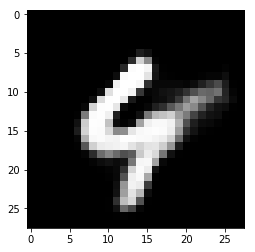

In [32]:
# sample and generate a image
z = torch.randn(1, LATENT_DIM).to(device)

# run only the decoder
reconstructed_img = model.dec(z).cpu()
img = reconstructed_img.view(28, 28).data

print(z.shape)
print(img.shape)

plt.imshow(img, cmap='gray')

torch.Size([1, 20])
torch.Size([28, 28])


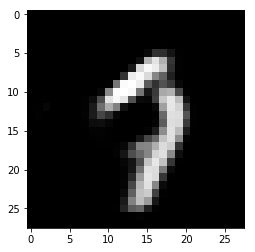

In [36]:
# sample and generate a image
z = torch.randn(1, LATENT_DIM).to(device)

# run only the decoder
reconstructed_img = model.dec(z).cpu()
img = reconstructed_img.view(28, 28).data

print(z.shape)
print(img.shape)

plt.imshow(img, cmap='gray')